In [1]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from catboost.utils import create_cd
from bayes_opt import BayesianOptimization

from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events

import config

%load_ext autoreload
%autoreload 2

DATA_PATH = config.get_data_path()

TRAIN_FEATURES = DATA_PATH / 'train_features.csv'
TEST_FEATURES = DATA_PATH / 'test_features.csv'

train_df = pd.read_csv(TRAIN_FEATURES, index_col=0, parse_dates=['event_dttm'])
test_df = pd.read_csv(TEST_FEATURES, index_col=0, parse_dates=['event_dttm'])

In [2]:
train_df['nearest_story_seconds_before'] = train_df['nearest_story_seconds_before'].abs()
test_df['nearest_story_seconds_before'] = test_df['nearest_story_seconds_before'].abs()

In [3]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

train_df = train_df.sort_values('event_dttm')

In [4]:
def postprocess_probs(probs, thresh):
    weights = np.array([[-10, -0.1, 0.1, 0.5]])
    probs = np.sum(probs * weights, axis=1)
    binarized = probs > thresh
    binarized = binarized * 2 - 1
    return binarized

def score(probs, y_true, thresh):
    answers = postprocess_probs(probs, thresh)
    id2w = config.id2w()
    true_weights = np.array(list(map(id2w.get, y_true)))
    our_score = (true_weights * answers).sum()
    best_score = np.abs(true_weights).sum()
    
    return our_score / best_score

def score_attrs(probs, y_true):
    answers = postprocess_probs(probs)
    id2w = config.id2w()
    true_weights = np.array(list(map(id2w.get, y_true)))
    our_score = np.cumsum(true_weights * answers)
    best_score = np.cumsum(np.abs(true_weights))
    
    return our_score, best_score

In [5]:
to_drop = ['is_weeked']

In [6]:
X_train_full = train_df.drop(
    ['event', 'event_dttm', 'answer_id'] + to_drop,
    axis=1
)
y_train_full = train_df['event']

X_test = test_df.drop(
    ['answer_id', 'event_dttm', 'event'] + to_drop,
    axis=1
)
answer_id = test_df['answer_id']

In [7]:
X_train_full['event_dttm'] = range(X_train_full.shape[0])
X_test['event_dttm'] = range(X_train_full.shape[0], X_train_full.shape[0] + X_test.shape[0])

In [8]:
cols_init = set(X_train_full.columns)

In [9]:
choose_your_destiny = cols_init
choose_your_destiny = set(choose_your_destiny) - set([
 'watched_prev',
 'watched_post',
 'watched_in_window_day',
 'watched_in_window_now',
 'watched_in_window_day_excluding', # lower
 'watched_in_window_week',
 'watched_in_window_week_excluding',
 'num_dots',
 'first_session_dttm'
]) 

In [10]:
X_train_selected = X_train_full[choose_your_destiny]
X_test_selected = X_test[choose_your_destiny]

In [11]:
cat_features_init = set(['customer_id', 'story_id',
                'product_0', 'product_1', 'product_2', 'product_3', 'product_4', 'product_5', 'product_6',
                'marital_status_cd', 'job_position_cd', 'prod_not_nan',
])

In [12]:
cat_features = cat_features_init - (cols_init - choose_your_destiny)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y_train_full, test_size=0.2, shuffle=False)

In [16]:
X_train.shape

(378512, 91)

In [19]:
sorted(X_train.columns)

['age',
 'children_cnt',
 'customer_id',
 'day',
 'event_dttm',
 'gender_cd',
 'group_number',
 'hour',
 'job_position_cd',
 'marital_status_cd',
 'mean_amount',
 'mean_font_size',
 'minute',
 'nearest_story_seconds_after',
 'nearest_story_seconds_before',
 'negative',
 'neutral',
 'num_elements',
 'num_guids',
 'num_messages',
 'num_pages',
 'num_trans',
 'num_urls',
 'positive',
 'prod_not_nan',
 'prod_sum_cls',
 'prod_sum_opn',
 'prod_sum_utl',
 'product_0',
 'product_1',
 'product_2',
 'product_3',
 'product_4',
 'product_5',
 'product_6',
 'skip',
 'speech',
 'std_amount',
 'std_amount_normalized',
 'stories_after_counter',
 'stories_at_all',
 'stories_before_counter',
 'story_id',
 'sum_amount',
 'sum_amount_if_airlines',
 'sum_amount_if_airlines_percentage',
 'sum_amount_if_auto_rental',
 'sum_amount_if_auto_rental_percentage',
 'sum_amount_if_business_service',
 'sum_amount_if_business_service_percentage',
 'sum_amount_if_clothes',
 'sum_amount_if_clothes_percentage',
 'sum_amo

In [128]:
params = {
    'iterations': 2200,
    'verbose': 0,
    'early_stopping_rounds': 100,
    'thread_count': 19,
    'loss_function': 'MultiClass',
    'bagging_temperature': 0,
    'depth': 8,
    'l2_leaf_reg': 1.6519704174730915,
    'max_ctr_complexity': 14,
    'model_size_reg': 0.6588411267391062,
    'random_strength': 0.8158788096777208
}

In [88]:
model = cb.CatBoostClassifier(**params)

model.fit(X_train_selected, y_train_full, 
          cat_features=cat_features, 
          eval_set=(X_val, y_val),
          plot=True,
)

In [62]:
def my_score(probs, y_true):
    answers = probs
    id2w = config.id2w()
    true_weights = np.array(list(map(id2w.get, y_true)))
    our_score = (true_weights * answers).sum()
    best_score = np.abs(true_weights).sum()
    
    return our_score / best_score

In [80]:
val_probs = model.predict_proba(X_val)
weights = np.array([[-10, -0.1, 0.1, 0.5]])
weighted_ans = np.sum(val_probs * weights, axis=1)

In [120]:
post = (weighted_ans > -0.015) * 2 - 1
post[np.abs(weighted_ans) < 0] = 0
print(np.sum(post > 0))

my_score(post, y_val)

50434


0.4422120408974094

In [ ]:
def get_model(**params):
    print(params)
    return cb.CatBoostClassifier(**params)

def validate(model, X_train, y_train, X_val, y_val, verbose=0):
    model.fit(X_train, y_train, 
          cat_features=cat_features, 
          eval_set=(X_val, y_val),
          plot=verbose,
    )
    print(model.get_all_params())
    probs = model.predict_proba(X_val)
    current_score = score(probs, y_val, thresh=-0.007)
    if verbose:
        print(current_score)
        
    return current_score

def evaluate_model(**params):
    params_init = {
        'iterations': 1000, 
        'verbose': 0,
        'use_best_model': True,
        'early_stopping_rounds': 100,
        'loss_function': 'MultiClass'
    }
    params_init.update(params)
    params_init['depth'] = int(params_init['depth'])
    params_init['bagging_temperature'] = int(params_init['bagging_temperature'])
    model = get_model(**params_init)
    current_score = validate(model, X_train, y_train, X_val, y_val, verbose=0)
    return current_score

In [75]:
pbounds = {
    'depth': (4, 12),
    'l2_leaf_reg': (1e-3, 1e2),
    'random_strength': (1e-2, 10),
    'bagging_temperature': (0, 10),
}

In [ ]:
optimizer = BayesianOptimization(evaluate_model, pbounds, random_state=4)

logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)

optimizer.maximize(init_points=1, n_iter=4)

optimizer.res

# optimized params you can find in ./logs.json

In [ ]:
probs = model.predict_proba(X_test_selected)

In [765]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=3:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 2200,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.1000000015,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 1.651970387,
 'random_strength': 0.8158788085,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 14,
 'model_size_reg': 0.6588411331,
 'approx_on_full_history': False,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=3:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorder

In [782]:
def make_submission(answers, answer_id, path):
    df = pd.DataFrame({'answer_id': answer_id, 'score': answers})
    df = df.sort_values('answer_id')
    df.to_csv(path, index=False)
    return df

In [783]:
answers = postprocess_probs(probs, +0.01)

In [784]:
np.mean(answers == 1)

0.5832524455242402

(array([ 71701.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 100348.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

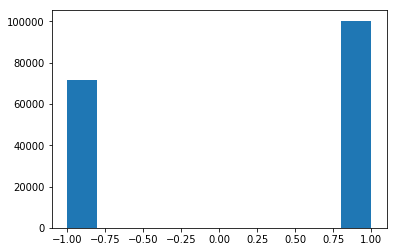

In [785]:
plt.hist(answers)

In [787]:
sub = make_submission(answers, answer_id, DATA_PATH / 'submissions' / 'full_22k_plus_01.csv')